In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from neo4j import GraphDatabase
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# --- Neo4j Aura Credentials ---
NEO4J_URI = "neo4j+s://23017e96.databases.neo4j.io"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "" #omitted for security

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))
driver.verify_connectivity()
session = driver.session(database="neo4j")

# Helper function to run queries and return a pandas DataFrame
def run_query(query, params={}):
    with driver.session(database="neo4j", default_access_mode="WRITE") as session:
        result = session.run(query, params)
        return pd.DataFrame([r.data() for r in result])

## 1. Basic Analysis: Degree Centrality (Most Connections)

Degree centrality is a simple count of how many relationships are connected to a node. For an airport, this tells us how many inbound and outbound routes it has. It's a fundamental measure of how "busy" an airport is.

In [53]:
# Cypher query to get the in-degree, out-degree, and total degree for each airport
degree_query = """
MATCH (a:Airport)
RETURN
  a.iata AS iata,
  COUNT { (a)<--() } AS in_degree,
  COUNT { (a)-->() } AS out_degree,
  COUNT { (a)--() } AS total_degree
ORDER BY total_degree DESC
LIMIT 15
"""

degree_df = run_query(degree_query)
print("Top 15 Airports by Total Degree (Number of Routes):")
display(degree_df)

Top 15 Airports by Total Degree (Number of Routes):


,iata,in_degree,out_degree,total_degree
0,DEN,111,112,223
1,ATL,106,106,212
2,ORD,104,105,209
3,DFW,94,95,189
4,MSP,86,86,172
5,LAS,83,83,166
6,DTW,81,81,162
7,CLT,80,80,160
8,SLC,64,63,127
9,PHL,64,63,127


Weather & Degree for Top 25 Busiest Airports (with recorded snow/precip):
   iata  total_degree  avg_max_temp  total_precip_mm  total_snow_mm
0   DEN           223      2.066880            38.34         1761.0
1   ORD           209      1.829000            73.01          539.0
2   MSP           172      0.095469            27.34          178.0
3   DTW           162      0.873613            33.81          420.0
4   PHL           127      2.177810            24.73           64.0
5   SLC           127      1.988400            43.93         1228.0
6   DCA           120      2.118440            72.51          249.0
7   IAD           110      2.118440            72.51          249.0
8   EWR           106      2.011714           127.94          478.0
9   MDW            97      1.829000            73.01          539.0
10  CLE            82      0.309677             1.90           10.0
11  STL            73      2.210661            87.11          153.0
12  PDX            71      1.771355       

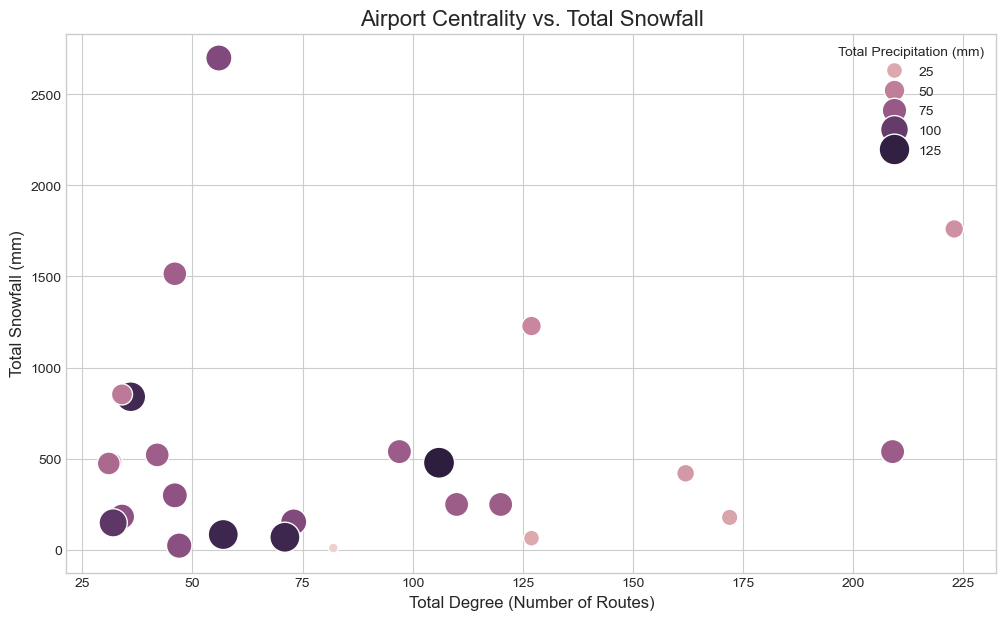

In [54]:
weather_integration_query = """
MATCH (a:Airport)
WHERE a.totalSnowMM > 0 AND a.totalPrecipMM > 0
WITH a, COUNT { (a)--() } AS total_degree
ORDER BY total_degree DESC
LIMIT 25
RETURN
  a.iata AS iata,
  total_degree,
  a.avgMaxTempC AS avg_max_temp,
  a.totalPrecipMM AS total_precip_mm,
  a.totalSnowMM AS total_snow_mm
"""
weather_df = run_query(weather_integration_query)

print("Weather & Degree for Top 25 Busiest Airports (with recorded snow/precip):")
print(weather_df)

# Visualization code
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data=weather_df, x='total_degree', y='total_snow_mm', hue='total_precip_mm', size='total_precip_mm', sizes=(50, 500), ax=ax)
ax.set_title('Airport Centrality vs. Total Snowfall', fontsize=16)
ax.set_xlabel('Total Degree (Number of Routes)', fontsize=12)
ax.set_ylabel('Total Snowfall (mm)', fontsize=12)
plt.legend(title='Total Precipitation (mm)')
plt.show()

Major Hubs Are in Snowy Regions: The busiest airports on this list—Denver (DEN), Chicago (ORD), Minneapolis (MSP), and Detroit (DTW)—all have high total_degree and receive significant snowfall. This directly confirms that critical nodes in the U.S. aviation network are located in areas prone to major winter weather events.

Snowfall Outliers Are Apparent: Anchorage (ANC) is a major outlier, with the highest snowfall by a large margin (2699 mm) despite having fewer connections than top-tier hubs. Denver (DEN), Salt Lake City (SLC), and Pittsburgh (PIT) also stand out with exceptionally high snowfall relative to other airports of similar size, making them critical points of interest for weather-related disruption analysis.

Centrality and Weather Aren't Always Linked: While many busy airports get a lot of snow, others like Philadelphia (PHL) have a high degree of connectivity but comparatively little snowfall (64 mm). This provides a useful contrast and shows that not all major hubs face the same level of winter risk.

## Link Predictions
Using the neo4j data, we can now introduce link prediciton where we can predict whether a connection would be likely to exist in the future. This may be interesting to airlines when they want to investigate whether a route would be profitable.

In [55]:
# Get all airport nodes with their properties
airports_query = """
MATCH (a:Airport)
WHERE a.totalSnowMM IS NOT NULL
RETURN a.iata AS iata,
       a.totalSnowMM AS snow,
       a.totalPrecipMM AS precip,
       COUNT{(a)--()} AS degree
"""
airport_results = session.run(airports_query)
airport_features_df = pd.DataFrame(airport_results.data()).set_index('iata')
print(f"Loaded features for {len(airport_features_df)} airports.")

# Get all existing routes
routes_query = """
MATCH (a1:Airport)-[:FLIES_TO]->(a2:Airport)
RETURN a1.iata AS origin, a2.iata AS destination
"""
routes_results = session.run(routes_query)
positive_samples_df = pd.DataFrame(routes_results.data())
print(f"Loaded {len(positive_samples_df)} existing routes.")

Loaded features for 421 airports.
Loaded 3100 existing routes.


In [56]:
all_airports = set(airport_features_df.index)
existing_routes = set(zip(positive_samples_df['origin'], positive_samples_df['destination']))

negative_samples = []
# Generate a balanced set of negative samples
while len(negative_samples) < len(positive_samples_df):
    origin, dest = random.sample(list(all_airports), 2)
    # Ensure the randomly generated route doesn't already exist
    if (origin, dest) not in existing_routes and (dest, origin) not in existing_routes:
        negative_samples.append({'origin': origin, 'destination': dest})

negative_samples_df = pd.DataFrame(negative_samples)

### Label data frame and engineer additional features

In [57]:
# Assign the target variable (1 for existing routes, 0 for non-existent)
positive_samples_df['target'] = 1
negative_samples_df['target'] = 0

# Combine positive and negative samples into one DataFrame
ml_df = pd.concat([positive_samples_df, negative_samples_df]).reset_index(drop=True)

# Join features for the origin airport
ml_df = ml_df.merge(airport_features_df, left_on='origin', right_index=True)
ml_df.rename(columns={'snow': 'origin_snow', 'precip': 'origin_precip', 'degree': 'origin_degree'}, inplace=True)

# Join features for the destination airport
ml_df = ml_df.merge(airport_features_df, left_on='destination', right_index=True)
ml_df.rename(columns={'snow': 'dest_snow', 'precip': 'dest_precip', 'degree': 'dest_degree'}, inplace=True)

# Create the preferential attachment feature (degree of origin * degree of destination)
ml_df['pref_attachment'] = ml_df['origin_degree'] * ml_df['dest_degree']

display(ml_df.head())

,origin,destination,target,origin_snow,origin_precip,origin_degree,dest_snow,dest_precip,dest_degree,pref_attachment
0,IRC,FAI,1,510.0,18.64,2,469.0,24.83,24,48
1,LMA,FAI,1,734.0,32.75,2,469.0,24.83,24,48
2,PVU,OAK,1,1228.0,43.93,4,0.0,113.32,31,124
3,PVU,AZA,1,1228.0,43.93,4,0.0,24.34,58,232
4,MMU,LUK,1,478.0,127.94,2,173.0,77.60,6,12


### Train Model

In [58]:
# Define the features to be used for training
features = [
    'origin_degree', 'origin_snow', 'origin_precip',
    'dest_degree', 'dest_snow', 'dest_precip',
    'pref_attachment'
]
X = ml_df[features]
y = ml_df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train the Random Forest model
print("Training Random Forest Classifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

Training Random Forest Classifier...


RandomForestClassifier(n_jobs=-1, random_state=42)

### Evaluate Model and Feature Importance


 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       930
           1       0.91      0.92      0.91       930

    accuracy                           0.91      1860
   macro avg       0.91      0.91      0.91      1860
weighted avg       0.91      0.91      0.91      1860


✨ Feature Importances:


,feature,importance
6,pref_attachment,0.423994
0,origin_degree,0.183857
3,dest_degree,0.174000
2,origin_precip,0.073075
5,dest_precip,0.071505
1,origin_snow,0.037381
4,dest_snow,0.036189


/var/folders/x5/tlnfn1690c57g1_tz3cvycb00000gn/T/ipykernel_3601/608289508.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')


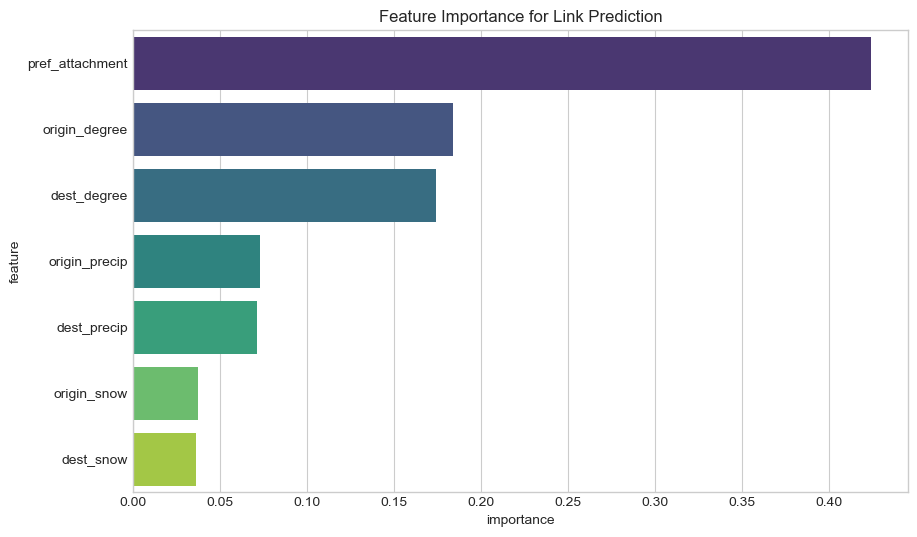

In [59]:
# Evaluate the model's performance on the test set
print("\n Classification Report:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Analyze Feature Importance

# Create a DataFrame to view feature importances
importance_df = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n✨ Feature Importances:")
display(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance for Link Prediction')
plt.show()

### Network Structure

The model's predictions are overwhelmingly driven by the network's existing structure.

pref_attachment is the most dominant feature by a wide margin. This means that the combined connectivity of two airports (the product of their individual number of routes) is the single best predictor. In simple terms, hubs are extremely likely to connect to other hubs.

origin_degree and dest_degree are the next most important features, reinforcing the same point. An airport's individual importance is a primary factor.

Together, these top three network features account for over 78% of the model's predictive power.

### Weather Plays a Supporting Role

While weather is a factor, it is significantly less influential than the network structure.

Precipitation (origin_precip, dest_precip) has a modest impact on the prediction.

Snowfall (origin_snow, dest_snow) is the least important factor the model considered.

In short, the model learned that to predict a new flight route, knowing how connected the airports already are is far more important than knowing what the weather is like at each location.